In [1]:
# 어떤 지점을 중심으로 골라진 n%의 샘플에 대해서만 적용한 경우
from myAE import Manager
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
manager = Manager()
manager.prepare_data()

def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager.set_default_model(4, 2)

In [3]:
hist = manager.train_on_cpu(calc_loss, epochs=30)

Now, it is working on cpu.


100%|██████████| 30/30 [05:09<00:00, 10.33s/it]


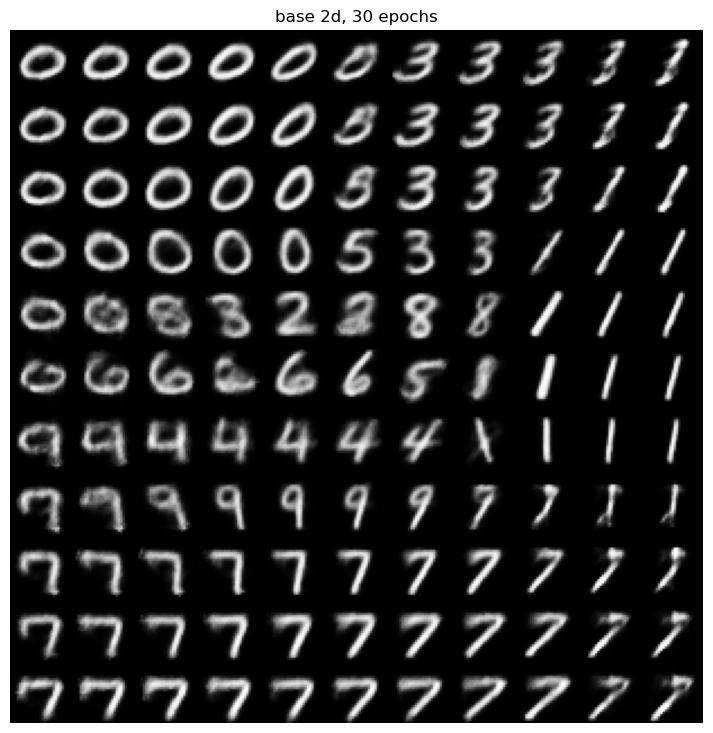

In [4]:
manager.plot_generated_images('base 2d, 30 epochs')

In [5]:
with torch.no_grad():
    # get latent vectors
    latent_vectors = manager.model.get_submodule('encoder')(manager.training_data)[:, :2]
print(latent_vectors.shape)    

torch.Size([60000, 2])


In [6]:
# from the origin get 6,000 points
origins = torch.zeros_like(latent_vectors)
lengths = F.mse_loss(latent_vectors, origins, reduction='none').sum(dim=1)
print(lengths.shape)

torch.Size([60000])


In [7]:
indices = torch.argsort(lengths)
print(lengths[indices[:10]])

tensor([5.1345e-05, 5.7400e-05, 1.5513e-04, 1.9894e-04, 2.4048e-04, 2.6615e-04,
        2.9199e-04, 3.8042e-04, 5.1819e-04, 6.3759e-04])


In [8]:
# select 6,000 random sample

from torch.utils.data import Dataset, DataLoader

class TmpDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

new_data = manager.training_data[indices[:6000]]
new_targets = torch.ones(6000)

new_dataloader = DataLoader(
    TmpDataset(new_data, new_targets), batch_size=128, shuffle=True
)

In [9]:
print(len(new_data))

6000


In [10]:
from torch import nn
from collections import OrderedDict

class My_Encoder(nn.Module):
    def __init__(self, dim_input, dim_encoder_output=2, activation="tanh"):
        super().__init__()

        if activation == "tanh":
            self.activation = torch.tanh
        elif activation == "sigmoid":
            self.activation = torch.sigmoid
        elif activation == "relu":
            self.activation = torch.relu

        self.l0 = nn.Linear(dim_input, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, dim_encoder_output)

    def forward(self, x):
        h = self.activation(self.l0(x))
        h = self.activation(self.l1(h))
        z = self.l2(h)
        return z


class My_Decoder(nn.Module):
    def __init__(self, dim_decoder_input, activation="tanh"):
        super().__init__()

        if activation == "tanh":
            self.activation = torch.tanh
        elif activation == "sigmoid":
            self.activation = torch.sigmoid
        elif activation == "relu":
            self.activation = torch.relu

        self.l0 = nn.Linear(dim_decoder_input, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, 784)
        self.unfln = nn.Unflatten(1, [1, 28, 28])

    def forward(self, z):
        x_hat = self.activation(self.l0(z))
        x_hat = self.activation(self.l1(x_hat))
        x_hat = torch.sigmoid(self.l2(x_hat))
        x_hat = self.unfln(x_hat)
        return x_hat

In [11]:
# make another network for 1 dimensionality and conditioned inputs
model = nn.Sequential(
    OrderedDict(
        [
            ("encoder", My_Encoder(784 + 2)), # with 2 condition -> mu and sigma out
            ("decoder", My_Decoder(3)),       # with 2 condition <- sample + 2
        ]
    )
)
optimizer = torch.optim.Adam(model.parameters())

In [12]:
from tqdm import tqdm

for _ in tqdm(range(30)):
    for x, y in new_dataloader:
        # get condition from the base model
        with torch.no_grad():
            condition = manager.model.get_submodule('encoder')(x)[:, :2] # with no sampling
        
        # flatten the input data
        x_flat = x.view(len(x), -1)

        # concat the condition and data
        x_condi_flat = torch.cat([condition, x_flat], dim=1)

        # run encoder
        h = model.get_submodule('encoder')(x_condi_flat)

        # sampling
        mu = h[:, :1]
        log_sigma = h[:, 1:]
        sigma = log_sigma.exp()
        z = torch.rand_like(mu) * sigma + mu

        # concat the condition and sample point
        z_condi = torch.cat([condition, z], dim=1)

        # run decoder
        pred = model.get_submodule("decoder")(z_condi)

        # calc recon loss and kl divergence
        kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
        ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
        loss = ll + kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 30/30 [00:19<00:00,  1.54it/s]


In [13]:
def get_tx(points):
    bases = []
    for p in points:
        bases.append(torch.ones(10, 1) * p)

    b = torch.linspace(-3, 3, 10).view(-1, 1)
    tx = torch.cat([*bases, b], dim=1)
    return tx


def show_ten_images(title, imgs):
    tmp = torch.zeros(28 * 10, 28)

    for idx, img in enumerate(imgs):
        tmp[idx * 28: (idx + 1) * 28, :28] = img.view(28, 28)
    
    plt.figure(figsize=(3, 15))
    plt.imshow(tmp, cmap='gray')
    plt.title(title, fontdict={'fontsize':20})
    plt.axis('off')
    plt.tight_layout()
    plt.show()

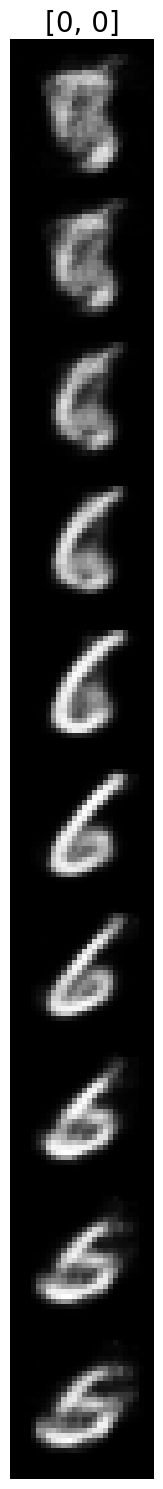

In [14]:
position = [0, 0]

tx = get_tx(position)

with torch.no_grad():
    pred = model.get_submodule('decoder')(tx)

show_ten_images(str(position), pred)

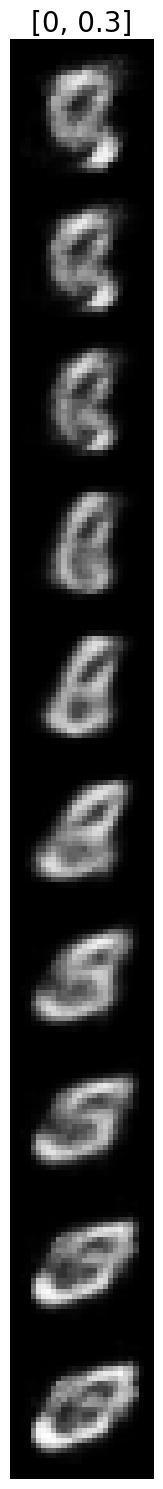

In [15]:
position = [0, 0.3]

tx = get_tx(position)

with torch.no_grad():
    pred = model.get_submodule('decoder')(tx)

show_ten_images(str(position), pred)

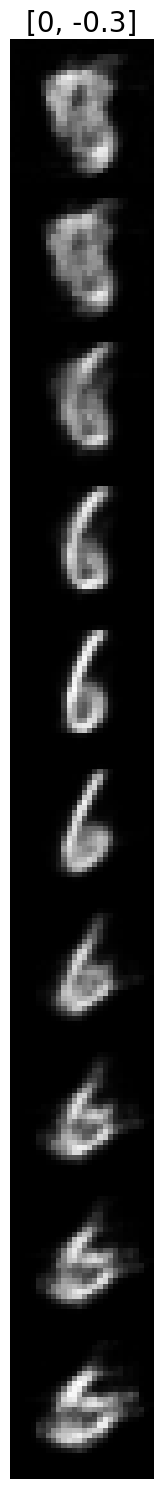

In [16]:
position = [0, -0.3]

tx = get_tx(position)

with torch.no_grad():
    pred = model.get_submodule('decoder')(tx)

show_ten_images(str(position), pred)

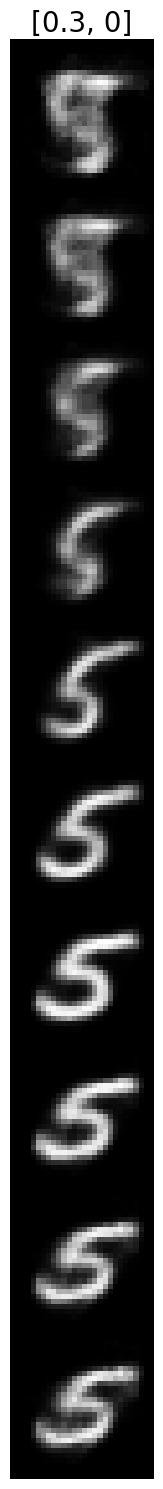

In [17]:
position = [0.3, 0]

tx = get_tx(position)

with torch.no_grad():
    pred = model.get_submodule('decoder')(tx)

show_ten_images(str(position), pred)

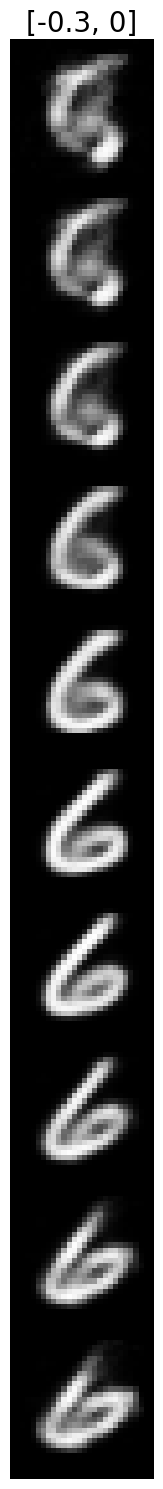

In [18]:
position = [-0.3, 0]

tx = get_tx(position)

with torch.no_grad():
    pred = model.get_submodule('decoder')(tx)

show_ten_images(str(position), pred)

In [21]:
a = torch.ones(60000, 1) * -1
b = torch.ones(60000, 1)
origins = torch.cat([a, b], dim=1)
lengths = F.mse_loss(latent_vectors, origins, reduction='none').sum(dim=1)

indices = torch.argsort(lengths)

# select 6,000 random sample

from torch.utils.data import Dataset, DataLoader

class TmpDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

new_data = manager.training_data[indices[:6000]]
new_targets = torch.ones(6000)

new_dataloader = DataLoader(
    TmpDataset(new_data, new_targets), batch_size=128, shuffle=True
)

In [22]:
# make another network for 1 dimensionality and conditioned inputs
model = nn.Sequential(
    OrderedDict(
        [
            ("encoder", My_Encoder(784 + 2)), # with 2 condition -> mu and sigma out
            ("decoder", My_Decoder(3)),       # with 2 condition <- sample + 2
        ]
    )
)
optimizer = torch.optim.Adam(model.parameters())

In [23]:
from tqdm import tqdm

for _ in tqdm(range(30)):
    for x, y in new_dataloader:
        # get condition from the base model
        with torch.no_grad():
            condition = manager.model.get_submodule('encoder')(x)[:, :2] # with no sampling
        
        # flatten the input data
        x_flat = x.view(len(x), -1)

        # concat the condition and data
        x_condi_flat = torch.cat([condition, x_flat], dim=1)

        # run encoder
        h = model.get_submodule('encoder')(x_condi_flat)

        # sampling
        mu = h[:, :1]
        log_sigma = h[:, 1:]
        sigma = log_sigma.exp()
        z = torch.rand_like(mu) * sigma + mu

        # concat the condition and sample point
        z_condi = torch.cat([condition, z], dim=1)

        # run decoder
        pred = model.get_submodule("decoder")(z_condi)

        # calc recon loss and kl divergence
        kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
        ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
        loss = ll + kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 30/30 [00:19<00:00,  1.53it/s]


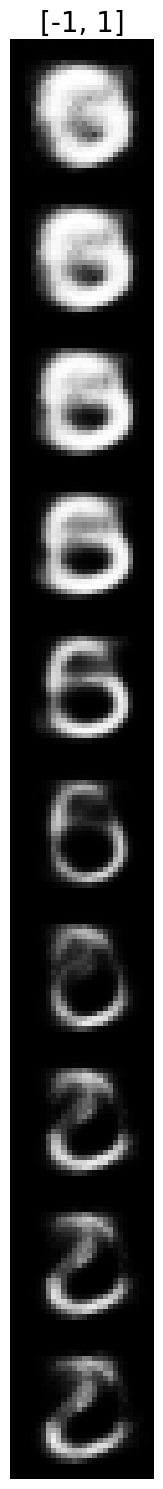

In [24]:
position = [-1, 1]

tx = get_tx(position)

with torch.no_grad():
    pred = model.get_submodule('decoder')(tx)

show_ten_images(str(position), pred)

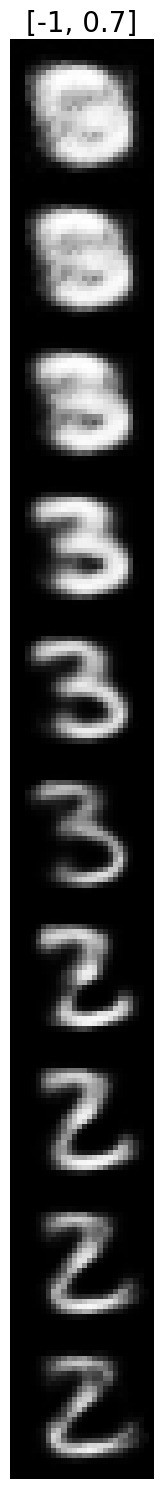

In [25]:
position = [-1, 0.7]

tx = get_tx(position)

with torch.no_grad():
    pred = model.get_submodule('decoder')(tx)

show_ten_images(str(position), pred)

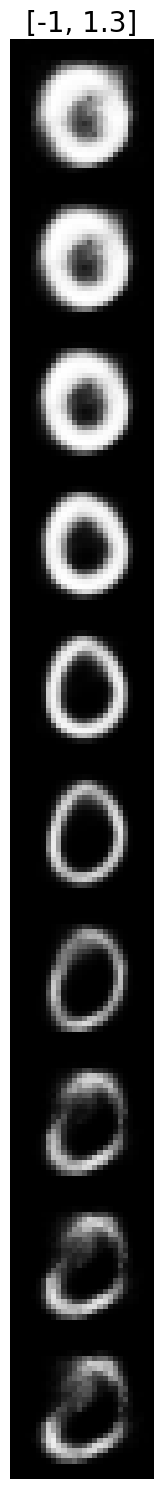

In [26]:
position = [-1, 1.3]

tx = get_tx(position)

with torch.no_grad():
    pred = model.get_submodule('decoder')(tx)

show_ten_images(str(position), pred)

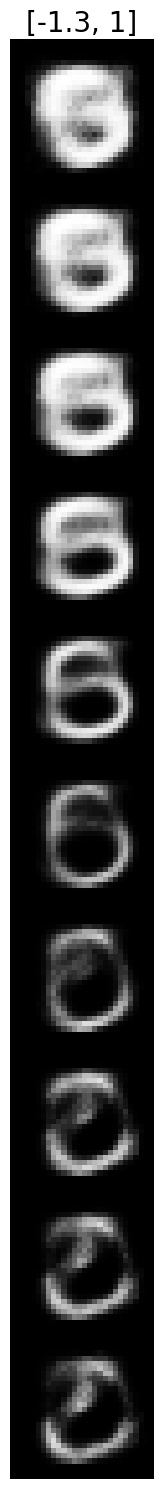

In [27]:
position = [-1.3, 1]

tx = get_tx(position)

with torch.no_grad():
    pred = model.get_submodule('decoder')(tx)

show_ten_images(str(position), pred)

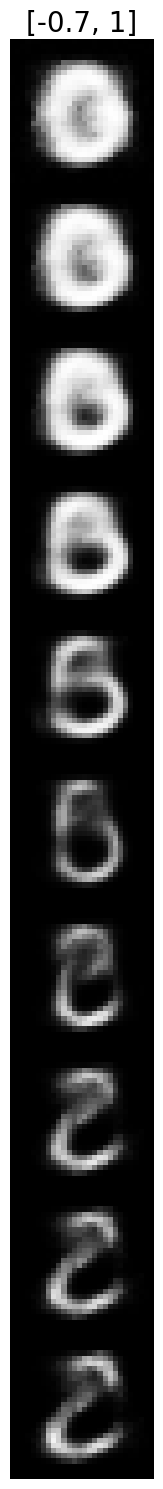

In [28]:
position = [-0.7, 1]

tx = get_tx(position)

with torch.no_grad():
    pred = model.get_submodule('decoder')(tx)

show_ten_images(str(position), pred)